In [58]:
import os
import shutil
import sys
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
#%tensorflow_version 1.12.0
import datetime
from keras.layers import Input, Dense, Lambda, multiply, Embedding, Flatten, LSTM,Dropout
import tensorflow as tf
import os
from keras.models import Model
from keras import objectives
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
from IPython.display import clear_output
from keras.regularizers import l2
import time

In [59]:
### change `DATA_DIR` to the location where our dataset sits
DATA_DIR = './Data/'

In [60]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
recode={i:j for i,j in zip(range(1,14),range(13,0,-1))}
raw_data['challenge_sequence']=raw_data['challenge_sequence'].map(recode)
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
test_data['challenge_sequence']=test_data['challenge_sequence'].map(dict((i,j) for i,j in zip(range(1,11),range(10,0,-1))))
challenge = pd.read_csv(os.path.join(DATA_DIR, 'challenge_data.csv'))

In [61]:
cols_to_one_hot=['programming_language','author_gender','author_ID','author_org_ID','challenge_series_ID','category_id']
for c in cols_to_one_hot:
    dummies=pd.get_dummies(challenge[c],prefix=c,drop_first=True)
    challenge=pd.concat([challenge,dummies],axis=1).drop(c,axis=1)
challenge['publish_date']=pd.to_datetime(challenge['publish_date'])
challenge['how_old']=challenge['publish_date'].apply(lambda d: (datetime.datetime.today()-d).days)
challenge.drop(['publish_date'],axis=1,inplace=True)
challenge.fillna(0,inplace=True)
challenge.head() 

,challenge_ID,total_submissions,programming_language_2,programming_language_3,author_gender_M,author_ID_AI563577,author_ID_AI563578,author_ID_AI563579,author_ID_AI563580,author_ID_AI563582,...,category_id_240.0,category_id_246.0,category_id_247.0,category_id_250.0,category_id_259.0,category_id_265.0,category_id_274.0,category_id_284.0,category_id_304.0,how_old
0,CI23478,37.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5144
1,CI23479,48.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6471
2,CI23480,15.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6472
3,CI23481,236.0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6134
4,CI23482,137.0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6681


In [199]:
#challenge data with imputation

'''
challenge['total_submissions']=np.where(challenge['total_submissions'].isna(),np.median(challenge['total_submissions'].dropna()),challenge['total_submissions'])
cols_to_one_hot=['programming_language','author_gender']

for c in cols_to_one_hot:
    dummies=pd.get_dummies(challenge[c],prefix=c,drop_first=True)
    challenge=pd.concat([challenge,dummies],axis=1).drop(c,axis=1)

challenge['challenge_series_ID']=np.where(challenge['challenge_series_ID']==np.nan,'SI2652',challenge['challenge_series_ID'])

challenge['publish_date']=pd.to_datetime(challenge['publish_date'])
challenge['how_old']=challenge['publish_date'].apply(lambda d: (datetime.datetime.today()-d).days)

challenge.drop(['publish_date','author_ID','author_org_ID','category_id'],axis=1,inplace=True)

from category_encoders.hashing import HashingEncoder

challenge=HashingEncoder(cols=['challenge_series_ID'],n_components=32).fit_transform(challenge)
'''

"\nchallenge['total_submissions']=np.where(challenge['total_submissions'].isna(),np.median(challenge['total_submissions'].dropna()),challenge['total_submissions'])\ncols_to_one_hot=['programming_language','author_gender']\n\nfor c in cols_to_one_hot:\n    dummies=pd.get_dummies(challenge[c],prefix=c,drop_first=True)\n    challenge=pd.concat([challenge,dummies],axis=1).drop(c,axis=1)\n\nchallenge['challenge_series_ID']=np.where(challenge['challenge_series_ID']==np.nan,'SI2652',challenge['challenge_series_ID'])\n\nchallenge['publish_date']=pd.to_datetime(challenge['publish_date'])\nchallenge['how_old']=challenge['publish_date'].apply(lambda d: (datetime.datetime.today()-d).days)\n\nchallenge.drop(['publish_date','author_ID','author_org_ID','category_id'],axis=1,inplace=True)\n\nfrom category_encoders.hashing import HashingEncoder\n\nchallenge=HashingEncoder(cols=['challenge_series_ID'],n_components=32).fit_transform(challenge)\n"

In [62]:
f=[]
l=[]
for i in range(20,100):
  l.append(5606%i)
  f.append(i)
sorted(zip(f,l), key=lambda x:x[1])[:3] 

[(59, 1), (95, 1), (20, 6)]

In [63]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
x_train1=MinMaxScaler().fit_transform(challenge.drop('challenge_ID',axis=1))
#x_train1=StandardScaler().fit_transform(challenge.drop('challenge_ID',axis=1))
x_train=x_train1[:-1]

Dimensionality reduction for challenge features

In [202]:
batch_size=59
original_dim=x_train.shape[1]
intermediate_dim1=600
#intermediate_dim2=100
#intermediate_dim3=50
latent_dim=6
nb_epochs=800
epsilon_std=1.0

x=Input(batch_shape=(batch_size,original_dim))
h1=Dense(intermediate_dim1, activation='relu')(x)
#h2=Dense(intermediate_dim2, activation='relu')(h1)
#h3=Dense(intermediate_dim3, activation='relu')(h2)

z_mean=Dense(latent_dim)(h1)
z_log_var=Dense(latent_dim)(h1)

def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon
z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

h_decoder=Dense(intermediate_dim1, activation='relu')
x_bar=Dense(original_dim,activation='sigmoid') 
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)

vae = Model(x, x_decoded)
def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss=-0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconst_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

def nn_batch_generator(x, y, batch_size, samples_per_epoch):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:]
        y_batch = y[index_batch,:]
        counter += 1
        yield (np.array(x_batch),np.array(y_batch))
        if (counter >= number_of_batches):
            counter=0


weightsPath = "./challenge_embed_weights.hdf5"
checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1)
#vae.load_weights(weightsPath)
vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, x_train.shape[0]), steps_per_epoch=x_train.shape[0]/batch_size, nb_epoch=nb_epochs, callbacks=[checkpointer])

/home/divyansh/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/divyansh/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=95.0, callbacks=[<keras.ca..., epochs=800)`


Epoch 1/800
95/95 [==============================] - 2s 24ms/step - loss: 771.9086

Epoch 00001: saving model to ./challenge_embed_weights.hdf5
Epoch 2/800
95/95 [==============================] - 1s 12ms/step - loss: 53.5409

Epoch 00002: saving model to ./challenge_embed_weights.hdf5
Epoch 3/800
95/95 [==============================] - 1s 12ms/step - loss: 44.5476

Epoch 00003: saving model to ./challenge_embed_weights.hdf5
Epoch 4/800
95/95 [==============================] - 1s 12ms/step - loss: 39.0307

Epoch 00004: saving model to ./challenge_embed_weights.hdf5
Epoch 5/800
95/95 [==============================] - 1s 12ms/step - loss: 36.3533

Epoch 00005: saving model to ./challenge_embed_weights.hdf5
Epoch 6/800
95/95 [==============================] - 1s 12ms/step - loss: 34.6366

Epoch 00006: saving model to ./challenge_embed_weights.hdf5
Epoch 7/800
95/95 [==============================] - 1s 12ms/step - loss: 33.6093

Epoch 00007: saving model to ./challenge_embed_weights.hdf

Epoch 58/800
95/95 [==============================] - 1s 12ms/step - loss: 20.8392

Epoch 00058: saving model to ./challenge_embed_weights.hdf5
Epoch 59/800
95/95 [==============================] - 1s 12ms/step - loss: 20.6406

Epoch 00059: saving model to ./challenge_embed_weights.hdf5
Epoch 60/800
95/95 [==============================] - 1s 12ms/step - loss: 20.6449

Epoch 00060: saving model to ./challenge_embed_weights.hdf5
Epoch 61/800
95/95 [==============================] - 1s 12ms/step - loss: 20.5762

Epoch 00061: saving model to ./challenge_embed_weights.hdf5
Epoch 62/800
95/95 [==============================] - 1s 12ms/step - loss: 20.4887

Epoch 00062: saving model to ./challenge_embed_weights.hdf5
Epoch 63/800
95/95 [==============================] - 1s 12ms/step - loss: 20.3860

Epoch 00063: saving model to ./challenge_embed_weights.hdf5
Epoch 64/800
95/95 [==============================] - 1s 12ms/step - loss: 20.2251

Epoch 00064: saving model to ./challenge_embed_weigh

Epoch 115/800
95/95 [==============================] - 1s 12ms/step - loss: 17.3402

Epoch 00115: saving model to ./challenge_embed_weights.hdf5
Epoch 116/800
95/95 [==============================] - 1s 12ms/step - loss: 17.3638

Epoch 00116: saving model to ./challenge_embed_weights.hdf5
Epoch 117/800
95/95 [==============================] - 1s 13ms/step - loss: 17.2800

Epoch 00117: saving model to ./challenge_embed_weights.hdf5
Epoch 118/800
95/95 [==============================] - 1s 12ms/step - loss: 17.2751

Epoch 00118: saving model to ./challenge_embed_weights.hdf5
Epoch 119/800
95/95 [==============================] - 1s 12ms/step - loss: 17.2294

Epoch 00119: saving model to ./challenge_embed_weights.hdf5
Epoch 120/800
95/95 [==============================] - 1s 12ms/step - loss: 17.2497

Epoch 00120: saving model to ./challenge_embed_weights.hdf5
Epoch 121/800
95/95 [==============================] - 1s 13ms/step - loss: 17.1581

Epoch 00121: saving model to ./challenge_embe

Epoch 228/800
95/95 [==============================] - 1s 12ms/step - loss: 14.7422

Epoch 00228: saving model to ./challenge_embed_weights.hdf5
Epoch 229/800
95/95 [==============================] - 1s 12ms/step - loss: 14.7356

Epoch 00229: saving model to ./challenge_embed_weights.hdf5
Epoch 230/800
95/95 [==============================] - 1s 12ms/step - loss: 14.7428

Epoch 00230: saving model to ./challenge_embed_weights.hdf5
Epoch 231/800
95/95 [==============================] - 1s 12ms/step - loss: 14.6711

Epoch 00231: saving model to ./challenge_embed_weights.hdf5
Epoch 232/800
95/95 [==============================] - 1s 12ms/step - loss: 14.6547

Epoch 00232: saving model to ./challenge_embed_weights.hdf5
Epoch 233/800
95/95 [==============================] - 1s 12ms/step - loss: 14.7157

Epoch 00233: saving model to ./challenge_embed_weights.hdf5
Epoch 234/800
95/95 [==============================] - 1s 12ms/step - loss: 14.7199

Epoch 00234: saving model to ./challenge_embe

Epoch 341/800
95/95 [==============================] - 1s 12ms/step - loss: 13.8983

Epoch 00341: saving model to ./challenge_embed_weights.hdf5
Epoch 342/800
95/95 [==============================] - 1s 12ms/step - loss: 13.8585

Epoch 00342: saving model to ./challenge_embed_weights.hdf5
Epoch 343/800
95/95 [==============================] - 1s 13ms/step - loss: 13.8379

Epoch 00343: saving model to ./challenge_embed_weights.hdf5
Epoch 344/800
95/95 [==============================] - 1s 13ms/step - loss: 13.7746

Epoch 00344: saving model to ./challenge_embed_weights.hdf5
Epoch 345/800
95/95 [==============================] - 1s 13ms/step - loss: 13.7847

Epoch 00345: saving model to ./challenge_embed_weights.hdf5
Epoch 346/800
95/95 [==============================] - 1s 12ms/step - loss: 13.8523

Epoch 00346: saving model to ./challenge_embed_weights.hdf5
Epoch 347/800
95/95 [==============================] - 1s 12ms/step - loss: 13.8433

Epoch 00347: saving model to ./challenge_embe

Epoch 454/800
95/95 [==============================] - 1s 12ms/step - loss: 13.4682

Epoch 00454: saving model to ./challenge_embed_weights.hdf5
Epoch 455/800
95/95 [==============================] - 1s 12ms/step - loss: 13.5487

Epoch 00455: saving model to ./challenge_embed_weights.hdf5
Epoch 456/800
95/95 [==============================] - 1s 12ms/step - loss: 13.5541

Epoch 00456: saving model to ./challenge_embed_weights.hdf5
Epoch 457/800
95/95 [==============================] - 1s 12ms/step - loss: 13.5521

Epoch 00457: saving model to ./challenge_embed_weights.hdf5
Epoch 458/800
95/95 [==============================] - 1s 12ms/step - loss: 13.6082

Epoch 00458: saving model to ./challenge_embed_weights.hdf5
Epoch 459/800
95/95 [==============================] - 1s 12ms/step - loss: 13.5623

Epoch 00459: saving model to ./challenge_embed_weights.hdf5
Epoch 460/800
95/95 [==============================] - 1s 12ms/step - loss: 13.5448

Epoch 00460: saving model to ./challenge_embe

Epoch 567/800
95/95 [==============================] - 1s 13ms/step - loss: 13.2727

Epoch 00567: saving model to ./challenge_embed_weights.hdf5
Epoch 568/800
95/95 [==============================] - 1s 12ms/step - loss: 13.2896

Epoch 00568: saving model to ./challenge_embed_weights.hdf5
Epoch 569/800
95/95 [==============================] - 1s 12ms/step - loss: 13.2694

Epoch 00569: saving model to ./challenge_embed_weights.hdf5
Epoch 570/800
95/95 [==============================] - 1s 12ms/step - loss: 13.3019

Epoch 00570: saving model to ./challenge_embed_weights.hdf5
Epoch 571/800
95/95 [==============================] - 1s 13ms/step - loss: 13.2714

Epoch 00571: saving model to ./challenge_embed_weights.hdf5
Epoch 572/800
95/95 [==============================] - 1s 12ms/step - loss: 13.3233

Epoch 00572: saving model to ./challenge_embed_weights.hdf5
Epoch 573/800
95/95 [==============================] - 1s 12ms/step - loss: 13.2857

Epoch 00573: saving model to ./challenge_embe

Epoch 680/800
95/95 [==============================] - 1s 12ms/step - loss: 13.1164

Epoch 00680: saving model to ./challenge_embed_weights.hdf5
Epoch 681/800
95/95 [==============================] - 1s 12ms/step - loss: 13.0848

Epoch 00681: saving model to ./challenge_embed_weights.hdf5
Epoch 682/800
95/95 [==============================] - 1s 12ms/step - loss: 13.1395

Epoch 00682: saving model to ./challenge_embed_weights.hdf5
Epoch 683/800
95/95 [==============================] - 1s 12ms/step - loss: 13.0879

Epoch 00683: saving model to ./challenge_embed_weights.hdf5
Epoch 684/800
95/95 [==============================] - 1s 12ms/step - loss: 13.1013

Epoch 00684: saving model to ./challenge_embed_weights.hdf5
Epoch 685/800
95/95 [==============================] - 1s 12ms/step - loss: 13.1282

Epoch 00685: saving model to ./challenge_embed_weights.hdf5
Epoch 686/800
95/95 [==============================] - 1s 12ms/step - loss: 13.1312

Epoch 00686: saving model to ./challenge_embe

Epoch 793/800
95/95 [==============================] - 1s 12ms/step - loss: 12.9379

Epoch 00793: saving model to ./challenge_embed_weights.hdf5
Epoch 794/800
95/95 [==============================] - 1s 12ms/step - loss: 13.0290

Epoch 00794: saving model to ./challenge_embed_weights.hdf5
Epoch 795/800
95/95 [==============================] - 1s 12ms/step - loss: 13.0231

Epoch 00795: saving model to ./challenge_embed_weights.hdf5
Epoch 796/800
95/95 [==============================] - 1s 12ms/step - loss: 13.0058

Epoch 00796: saving model to ./challenge_embed_weights.hdf5
Epoch 797/800
95/95 [==============================] - 1s 12ms/step - loss: 12.8933

Epoch 00797: saving model to ./challenge_embed_weights.hdf5
Epoch 798/800
95/95 [==============================] - 1s 12ms/step - loss: 12.9607

Epoch 00798: saving model to ./challenge_embed_weights.hdf5
Epoch 799/800
95/95 [==============================] - 1s 12ms/step - loss: 13.0106

Epoch 00799: saving model to ./challenge_embe

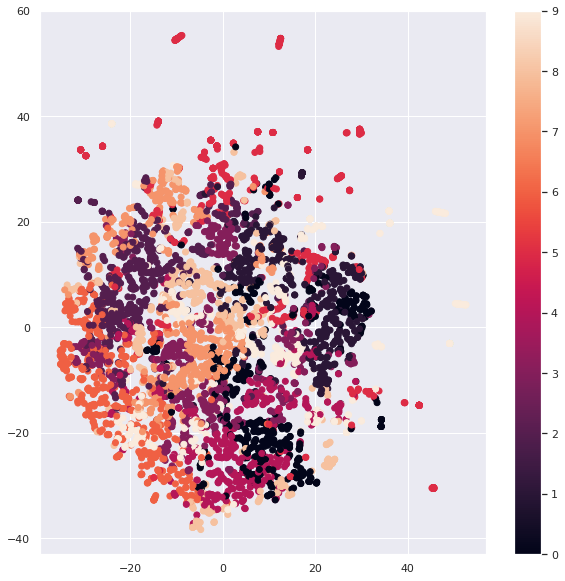

In [225]:
encoder = Model(x, z_mean)
challenge_encodings1=encoder.predict(x_train,batch_size=batch_size)
challenge_encodings2=encoder.predict(x_train1[1:],batch_size=batch_size)

challenge_encodings=np.append(challenge_encodings1,challenge_encodings2[-1:,:],axis=0)
# Visualizing challenge embeddings

from sklearn.cluster import KMeans
#!pip install bhtsne
from bhtsne import tsne

kmeans = KMeans(n_clusters=10, random_state=0).fit(challenge_encodings)
x_train_cluster_labels = kmeans.labels_

x_train_2_embedded = tsne(challenge_encodings.astype('float64'))

plt.figure(figsize=(10, 10))
plt.scatter(x_train_2_embedded[:, 0], x_train_2_embedded[:, 1], c=x_train_cluster_labels)
plt.colorbar()
plt.show()

In [204]:
np.save('./challenge_encodings.npy',challenge_encodings)

- Select 3K users as validation users, and the rest of the users for training

In [64]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [65]:
def filter_triplets(tp, min_uc=10, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'challenge')
        tp = tp[tp['challenge'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'user_id')
        tp = tp[tp['user_id'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'user_id'), get_count(tp, 'challenge') 
    return tp, usercount, itemcount

In [66]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

In [67]:
raw_data.shape

(903916, 4)

In [68]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d events from %d users and %d challenges (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 903916 events from 69532 users and 5348 challenges (sparsity: 0.243%)


In [132]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [133]:
# create train/validation/test users
n_users = unique_uid.size
n_validation_users = 12000
#n_validation_users = 1000

tr_users = unique_uid[:(n_users - n_validation_users )]
vd_users = unique_uid[(n_users - n_validation_users):]

In [134]:
train_plays = raw_data.loc[raw_data['user_id'].isin(tr_users)]
unique_sid = pd.unique(challenge['challenge_ID'])
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)  

In [135]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('user_id')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        
        n_user_item=len(group)
        idx = np.zeros(n_user_item, dtype='bool')
        idx[:10] = True

        te_list.append(group[np.logical_not(idx)])
        tr_list.append(group[idx])

        if i % 1000 == 0:
          print("%d users sampled" % i)
          sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [136]:
vad_plays = raw_data.loc[raw_data['user_id'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['challenge'].isin(unique_sid)]
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled


In [137]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['user_id']))
    sid = list(map(lambda x: show2id[x], tp['challenge']))
    #rating = list(tp['challenge_sequence'])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [138]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [139]:
challenge_encodings=np.load('./challenge_encodings.npy')

In [140]:
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

from scipy.special import softmax

def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']

    #vals=softmax(np.arange(13,0,-1))
    vals=np.ones_like(np.arange(1,14))
    data = sparse.csr_matrix((np.repeat(vals,len(set(rows))),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))   

In [141]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)
    
    tp_te = pd.concat([tp_tr,tp_te],axis=0)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']
        
    tr_counts=get_count(tp_tr, 'uid')
    te_counts=get_count(tp_te, 'uid')

#     sc=[]
#     sc.extend([softmax(np.arange(tr_counts.iloc[i],0,-1)) for i in range(len(tr_counts))])
#     tr_sc = np.concatenate(sc)
    sc=[]
    sc.extend([softmax(np.arange(te_counts.iloc[i],0,-1)) for i in range(len(te_counts))])
    te_sc = np.concatenate(sc)

    tr_sc=np.ones_like(range(tp_tr.shape[0]))

    data_tr = sparse.csr_matrix((tr_sc,
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((te_sc,
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'),
                                           os.path.join(pro_dir, 'validation_te.csv'))   

In [142]:
print(train_data.shape,vad_data_tr.shape,vad_data_te.shape)

(57532, 5606) (12000, 5606) (12000, 5606)


In [143]:
test_data.head()

,user_sequence,user_id,challenge_sequence,challenge
0,4577_1,4577,10,CI23855
1,4577_2,4577,9,CI23933
2,4577_3,4577,8,CI24917
3,4577_4,4577,7,CI24915
4,4577_5,4577,6,CI23714


In [144]:
# Formatting test data

def test_matrix(data):
    te_counts=data.groupby('user_id').size()

    cols_tr = list(map(lambda x: show2id[x], data['challenge']))
    cols_te = cols_tr
    rows_tr = [np.repeat(i,cnts) for i,cnts in enumerate(te_counts)]
    rows_tr = np.concatenate(rows_tr)
    rows_te = rows_tr

    sc=[]
    sc.extend([softmax(np.arange(te_counts.iloc[i],0,-1)) for i in range(len(te_counts))])
    te_sc = np.concatenate(sc)

    tr_sc=np.ones_like(range(test_data.shape[0]))

    data_te_tr = sparse.csr_matrix((tr_sc,
                                 (rows_tr, cols_tr)), dtype='float64', shape=(len(te_counts), n_items))          

    data_te_te = sparse.csr_matrix((te_sc,
                                 (rows_te, cols_te)), dtype='float64', shape=(len(te_counts), n_items))
    return data_te_tr,data_te_te

data_te_tr,data_te_te=test_matrix(test_data)

In [145]:
f=[]
l=[]
for i in range(200,510):
  l.append(train_data.shape[0]%i)
  f.append(i)
sorted(zip(f,l), key=lambda x:x[1])[:3]  

[(381, 1), (453, 1), (204, 4)]

In [146]:
f=[]
l=[]
for i in range(200,510):
  l.append(vad_data_tr.shape[0]%i)
  f.append(i)
sorted(zip(f,l), key=lambda x:x[1])[:3] 

[(200, 0), (240, 0), (250, 0)]

In [147]:
train_data=train_data[:-1]

Training Hybrid VAE for ratings prediction using user, joke ids, ratings and joke text information

In [102]:
# encoder/decoder network size
batch_size=453
original_dim=train_data.shape[1] # number of challenges
intermediate_dim1=600
#intermediate_dim2=400
#intermediate_dim3=200

latent_dim=200
nb_epochs=40
epsilon_std=1.0

#chal_indices = np.array([range(1,5607)])
#chal_indices = np.repeat(chal_indices, batch_size, axis = 0)

val_drop_idx=-(vad_data_tr.shape[0]%batch_size)
test_drop_idx=-(data_te_tr.shape[0]%batch_size)
#val_chal_indices = np.array([range(1,5607)])
#val_chal_indices = np.repeat(val_chal_indices,vad_data_tr.shape[0]+val_drop_idx,axis=0)

vocab_size = train_data.shape[1]
embed_dim = 6
seq_length = train_data.shape[1]

embedding_matrix = np.append(np.array([[0.0, 0.0, 0.0,0.0,0.0,0.0]]) ,np.array(challenge_encodings), axis =0)

In [103]:
lam =0.000005  # Weight decay on final hidden layer
anneal_ph=0.1  # Weight on KL divergence term in loss function
drop_prob=0.05 # Input dropout rate


In [104]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

# Callback for getting validation set MAP values
class ValMAP(Callback):

    def on_train_begin(self, logs={}):
        self.Val_MAP = []
        self.val_targ = 0
        self.val_predict = 0
        self.i=0
        self.x=[]
    '''self.validation_data:
    [<2814x5606 sparse matrix of type '<class 'numpy.float64'>'
	with 28140 stored elements in Compressed Sparse Row format>, 
     <2814x5606 sparse matrix of type '<class 'numpy.float64'>'
	with 28140 stored elements in Compressed Sparse Row format>, 
     array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), 
     0.0]'''    
        
    def on_epoch_end(self, epoch, logs):
        valdata=self.validation_data[0].toarray()
        self.val_targ = vad_data_te[:val_drop_idx,:].toarray()  # Checking validation results
        #self.val_targ = data_te_te[:test_drop_idx,:].toarray() # Checking test results
            # 5.4.1.2 Get the batch prediction values
        self.val_predict = np.asarray(self.model.predict(
                                valdata,batch_size=batch_size))

        def get_challenge_preds(v):
          idx=np.argsort(v)[::-1]
          #return np.array([id2show[i] for i in idx])
          return np.array(idx)

        vad_ch_preds=np.apply_along_axis(get_challenge_preds, 1, self.val_predict)
        sorted_vad_data_te = np.apply_along_axis(get_challenge_preds, 1, self.val_targ)

        # MAP@k for last three predictions
        def get_MAP(vadt,pred,k):
          ap_users=[]
          for userno,row in enumerate(vadt):
            prec=[]
            matches=0
            pred3 = [p for p in pred[userno] if p not in vadt[userno][:10]][:3] # for last 3 check
            for i in range(k):
              #rel=pred[userno][i] in vadt[userno]
              rel=pred3[i] in vadt[userno][-3:]
              if rel==1:
                matches+=1
              p=matches/(i+1)
              prec.append(p*rel)
            prec[prec==0]=np.nan
            ap_users.append(np.nanmean(prec))
          return np.mean(ap_users)

        #k=13
        k=3
        self.Val_MAP.append(get_MAP(sorted_vad_data_te[:,:13],vad_ch_preds[:,:13],k)) 
        logs["Val_MAP"] = self.Val_MAP
        #print(f"MAP for validation set is: {self.Val_MAP}")
        self.i+=1
        self.x.append(self.i)
        clear_output(wait=True)
        plt.plot(self.x, self.Val_MAP, label="MAP on Validation data")
        plt.legend()
        plt.show()
        return

validation_map = ValMAP()

In [105]:
# encoder network
x=Input(batch_shape=(batch_size,original_dim))
#h=Lambda(tf.math.l2_normalize, output_shape=(batch_size,original_dim), arguments={'axis':1})(x)
#m = tf.math.multiply(x,K.constant(np.array([range(1,5607)])))
d=Dropout(drop_prob)(x)
embedding_layer = Embedding(vocab_size+1, embed_dim, weights=[embedding_matrix], input_length=seq_length, trainable=True)
embed = embedding_layer(d)
flat_embed = Flatten()
embed = flat_embed(embed)
h1=Dense(intermediate_dim1,kernel_regularizer=l2(lam), activation='tanh')(embed)
#h2=Dense(intermediate_dim2,kernel_regularizer=l2(lam), activation='relu')(h1)
#h3=Dense(intermediate_dim3,kernel_regularizer=l2(lam), activation='tanh')(h2)

z_mean=Dense(latent_dim)(h1)
z_log_var=Dense(latent_dim,kernel_initializer="zeros")(h1)

In [106]:
# sampling from latent dimension for decoder/generative part of network
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [107]:
# decoder network
#h_decoder1=Dense(intermediate_dim1, activation='relu')
#h_decoder2=Dense(intermediate_dim2, activation='relu')
#h_decoder3=Dense(intermediate_dim3, activation='relu')
#h_decoder4=Dense(intermediate_dim4, activation='tanh')
h_decoder=Dense(intermediate_dim1,kernel_regularizer=l2(lam),activation='tanh')

x_bar=Dense(original_dim, activation='softmax')
#h_decoded1 = h_decoder1(z)
#h_decoded2 = h_decoder2(h_decoded1)
#h_decoded3 = h_decoder3(h_decoded2)
#h_decoded4 = h_decoder4(h_decoded3)
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)

#mul_inp = Input(batch_shape=(batch_size,original_dim))
#x_decoded = multiply([x_decoded, mul_inp])
#vae = Model([x, mul_inp], x_decoded)

vae = Model(x, x_decoded)

def vae_loss(x,x_bar):
    #mask = tf.greater_equal(x, 1) # Masking values corresponding to missing items for each user
    #reconst_loss=tf.reduce_mean(tf.boolean_mask(tf.pow(x_decoded - x,2), mask))
    #reconst_loss = original_dim*objectives.binary_crossentropy(x, x_bar)
    #reconst_loss=original_dim*objectives.mse(x,x_bar)
    reconst_loss = -tf.reduce_sum(multiply([x, K.log(x_bar)]))
    kl_loss=-0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconst_loss + anneal_ph*kl_loss

In [108]:
vae.compile(optimizer='adam', loss=vae_loss)
print(vae.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (445, 5606)          0                                            
__________________________________________________________________________________________________
dropout_4 (Dropout)             (445, 5606)          0           input_4[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (445, 5606, 6)       33642       dropout_4[0][0]                  
__________________________________________________________________________________________________
flatten_4 (Flatten)             (445, 33636)         0           embedding_4[0][0]                
____________________________________________________________________________________________

In [109]:
print("number of training users: ", train_data.shape[0])

number of training users:  68530


In [110]:
model_type='weights_beta_'+str(anneal_ph)+'_dropout_'+str(drop_prob)+'_weightdecay_'+str(lam)

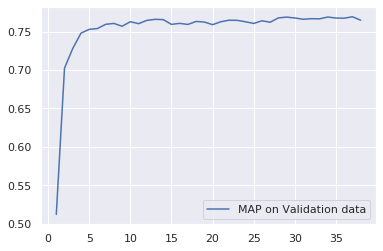

Total time taken: 0:09:24


In [111]:
def nn_batch_generator(x, y, batch_size, samples_per_epoch):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    while 1:
        x_batch = x[batch_size*counter:batch_size*(counter+1)].todense().astype(float)
        #x_new_batch = np.multiply(x_batch,chal_indices)
        counter += 1
        yield (x_batch, x_batch)
        #yield ([x_new_batch,x_batch], x_batch)
        if (counter >= number_of_batches):
            counter=0

if not os.path.exists('./model_vae'):
    os.makedirs('./model_vae')

weightsPath = "./model_vae/"+model_type+".hdf5"
checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)

t0=time.time()
#vae.load_weights(weightsPath)

# with validation
vae.fit_generator(nn_batch_generator(train_data, train_data, batch_size, train_data.shape[0]) ,
                  steps_per_epoch=train_data.shape[0]/batch_size, epochs=nb_epochs,
                  validation_data=(vad_data_tr[:val_drop_idx,:],vad_data_tr[:val_drop_idx,:]),
                    callbacks = [checkpointer,reduce_lr,plot_losses,validation_map])


# with test

# vae.fit_generator(nn_batch_generator(train_data, train_data, batch_size, train_data.shape[0]) ,
#                   steps_per_epoch=train_data.shape[0]/batch_size, epochs=nb_epochs,
#                   validation_data=(data_te_tr[:test_drop_idx,:],data_te_tr[:test_drop_idx,:]),
#                     callbacks = [checkpointer,reduce_lr,plot_losses,validation_map])



t1=time.time()
print("Total time taken: %s" %(str(datetime.timedelta(seconds=int(round(t1-t0))))))

# vae.fit_generator(nn_batch_generator(train_data, train_data, batch_size, train_data.shape[0]) , steps_per_epoch=train_data.shape[0]/batch_size, nb_epoch=nb_epochs,
#                    validation_data=([np.multiply(vad_data_tr[:val_drop_idx,:].toarray(),val_chal_indices),
#                                                        vad_data_tr[:val_drop_idx,:]],vad_data_tr[:val_drop_idx,:]),
#                   callbacks = [checkpointer,reduce_lr,plot_losses,validation_map])

In [112]:
np.argsort(validation_map.Val_MAP)[::-1]

array([36, 33, 28, 27, 29, 34, 35, 31, 32, 30, 12, 13, 21, 37, 22, 11, 25,
       17,  9, 23, 20, 18, 26, 15,  7, 24, 10,  6, 14, 16, 19,  8,  5,  4,
        3,  2,  1,  0])

In [115]:
weightsPath = "./model_vae/"+model_type+".hdf5"
vae.load_weights(weightsPath)

Making predictions for test set using trained VAE



In [116]:
test_preds1=vae.predict(data_te_tr[:test_drop_idx,:],batch_size=batch_size)
test_preds2=vae.predict(data_te_tr[-1*test_drop_idx:,:],batch_size=batch_size)
test_preds=np.append(test_preds1,test_preds2[test_drop_idx:,:],axis=0)

# Get predicted challenges in order from vae model

id2show = {v: k for k, v in show2id.items()}

def get_challenge_preds(v):
  idx=np.argsort(v)[::-1]
  return np.array(idx)

test_ch_preds=np.apply_along_axis(get_challenge_preds, 1, test_preds)

In [117]:
user_dict={}
test_users=list(test_data.user_id.unique())
for i,u in enumerate(test_users):
    user_dict[u]=test_ch_preds[:,:13][i]
    
test_preds_df=pd.DataFrame(user_dict)   
#test_preds_df=test_preds_df.replace(id2show)
test_preds_df.head()

,4577,4578,4579,4583,4584,4586,4588,4589,4594,4595,...,113811,113814,113820,113821,113826,113829,113830,113831,113834,113838
0,2249,303,3446,303,451,236,303,2672,1480,2676,...,1646,480,1397,185,709,1820,184,1393,1461,1052
1,1052,236,3448,370,1648,1648,236,2670,236,2670,...,752,370,1546,497,1772,1819,752,2763,1446,134
2,1480,185,3447,185,2255,185,1052,2677,497,2677,...,303,476,1657,1657,1052,185,948,2578,1143,660
3,1657,1439,3445,236,370,497,1480,2676,185,2680,...,402,377,1544,455,435,871,213,455,1453,236
4,1439,1480,3449,1657,497,1049,497,2671,455,2678,...,451,2255,451,1439,1437,870,292,1490,1449,455


In [118]:
test_preds_df=test_preds_df.T
#test_preds_df=test_preds_df.replace(id2show)

In [119]:
def get_challenge_preds(v):
  idx=np.argsort(v)[::-1]
  return np.array(idx)

dat=data_te_te.toarray()

In [120]:
test_ch_actual=np.apply_along_axis(get_challenge_preds, 1, dat)

user_dict2={}
for i,u in enumerate(test_users):
    user_dict2[u]=test_ch_actual[:,:13][i]
    
test_actual_df=pd.DataFrame(user_dict2)   

In [121]:
test_actual_df=test_actual_df.T

In [122]:
test_actual_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
4577,377,455,1439,1437,236,185,1480,1657,2249,1052,5605,1867,1868
4578,185,377,1439,455,497,236,1657,1437,1480,303,1868,1869,1870
4579,3443,3444,3445,3446,3447,3448,3449,3451,3452,3458,1874,1869,1870
4583,185,377,497,236,370,455,1657,303,1052,189,1875,1871,1867
4584,377,497,1657,370,236,1439,451,2255,1648,435,5605,1867,1868


In [123]:
test_preds_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
4577,2249,1052,1480,1657,1439,455,236,185,377,1437,497,2573,370
4578,303,236,185,1439,1480,497,455,377,1657,1437,370,1049,1648
4579,3446,3448,3447,3445,3449,3458,3451,3443,3444,3452,3462,3453,3456
4583,303,370,185,236,1657,189,1052,497,455,377,1049,1439,213
4584,451,1648,2255,370,497,236,1439,377,435,1657,1664,1049,185


In [124]:
test_preds_actual1=pd.concat([test_preds_df,test_actual_df],axis=1)

In [125]:
def get_lastthree(row):
   plist=list(row)[:13]
   alist=list(row)[13:-3] 
   return [p for p in plist if p not in alist][:3]           
        
test_preds_actual1['challenge']=test_preds_actual1.apply(lambda row: get_lastthree(row),axis=1)
test_preds_actual1.head()

,0,1,2,3,4,5,6,7,8,9,...,4,5,6,7,8,9,10,11,12,challenge
4577,2249,1052,1480,1657,1439,455,236,185,377,1437,...,236,185,1480,1657,2249,1052,5605,1867,1868,"[497, 2573, 370]"
4578,303,236,185,1439,1480,497,455,377,1657,1437,...,497,236,1657,1437,1480,303,1868,1869,1870,"[370, 1049, 1648]"
4579,3446,3448,3447,3445,3449,3458,3451,3443,3444,3452,...,3447,3448,3449,3451,3452,3458,1874,1869,1870,"[3462, 3453, 3456]"
4583,303,370,185,236,1657,189,1052,497,455,377,...,370,455,1657,303,1052,189,1875,1871,1867,"[1049, 1439, 213]"
4584,451,1648,2255,370,497,236,1439,377,435,1657,...,236,1439,451,2255,1648,435,5605,1867,1868,"[1664, 1049, 185]"


In [126]:
test_preds_actual1['user_sequence']=test_preds_actual1.index

In [127]:
test_preds_actual=test_preds_actual1.iloc[:,-2:]
test_preds_actual=test_preds_actual.explode('challenge')
test_preds_actual.head()

,challenge,user_sequence
4577,497,4577
4577,2573,4577
4577,370,4577
4578,370,4578
4578,1049,4578


In [128]:
test_preds_actual.reset_index(inplace=True)
test_preds_actual['user_sequence']=test_preds_actual['user_sequence'].astype('str')+'_'+pd.Series(['11','12','13']*len(test_users))
test_preds_actual=test_preds_actual.drop('index',axis=1)
test_preds_actual=test_preds_actual.replace(id2show)
test_preds_actual.head()

,challenge,user_sequence
0,CI23975,4577_11
1,CI26051,4577_12
2,CI23848,4577_13
3,CI23848,4578_11
4,CI24527,4578_12


In [129]:
assert test_preds_actual.shape[0]==3*len(test_users),"incorrect dimensions, check the data"

In [130]:
test_preds_actual.to_csv('./submission3.csv',index=False,header=True)

In [131]:
encoder = Model(x, z_mean)
train_encoded = encoder.predict(train_data.toarray(), batch_size=batch_size)
print(train_encoded.shape)

# Visualizing user embeddings

from sklearn.cluster import KMeans
from bhtsne import tsne

kmeans = KMeans(n_clusters=10, random_state=0).fit(train_encoded)
x_train_cluster_labels = kmeans.labels_

x_train_2_embedded = tsne(train_encoded.astype('float64'))

plt.figure(figsize=(10, 10))
plt.scatter(x_train_2_embedded[:, 0], x_train_2_embedded[:, 1], c=x_train_cluster_labels)
plt.colorbar()
plt.show()

MemoryError: 